### Imports

In [1]:
# Import libraries needed for webscraping
import requests
from datetime import datetime
import time
import random
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import regex as re
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import praw
from psaw import PushshiftAPI

pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

### Load Data

In [2]:
#travel_df1 = pd.read_csv('../data/travel_post_4000.csv')
#travel_df2 = pd.read_csv('../data/travel_post_8000.csv')
#travel_df = pd.read_csv('../data/travel_post_20000.csv')

In [2]:
awardtravel = pd.read_csv('../data/awardtravel_4000.csv')
#awardtravel_df2 = pd.read_csv('../data/awardtravel_8000.csv')
#awardtravel_df = pd.read_csv('../data/awardtravel_12000.csv')

In [4]:
#backpacking_df1 = pd.read_csv('../data/backpacking_4000.csv')
#backpacking_df2 = pd.read_csv('../data/backpacking_8000.csv')
#backpacking_df = pd.read_csv('../data/backpacking_12000.csv')

In [5]:
#cruise_df1 = pd.read_csv('../data/cruise_4000.csv')
#cruise_df2 = pd.read_csv('../data/cruise_8000.csv')
#cruise_df = pd.read_csv('../data/cruise_12000.csv')

In [3]:
travelhacks = pd.read_csv('../data/TravelHacks_4000.csv')
#travelhacks_df2 = pd.read_csv('../data/TravelHacks_8000.csv')
#travelhacks_df = pd.read_csv('../data/TravelHacks_12000.csv')

### Basic data cleaning

#### Check for removed, deleted, NaN posts
    Instead of dropping those value, I replaced them with empty string because the titles still capatured the information about the posts.  

In [4]:
travelhacks.head()

subreddit                                           selftext  \
0  TravelHacks                                          [removed]   
1  TravelHacks  Apologies if this type of question has been as...   
2  TravelHacks                                          [removed]   
3  TravelHacks  I'm planning my first international trip with ...   
4  TravelHacks                                          [removed]   

                                               title  distinguished  \
0  Things I can get my boyfriend for his 1 month ...            NaN   
1                         Cheap last minute flights?            NaN   
2                                               trip            NaN   
3          Any CFAR insurance options after 21 days?            NaN   
4                                                Egi            NaN   

                 author removed_by_category  num_comments utc_datetime_str  
0  AdministrativeLog689           moderator             0   4/1/2023 21:37  
1              anon_157                 NaN             0   4/1/2023 21:06  
2  Curious-Campaign2376           moderator             0   4/1/2023 19:08  
3      sweettangerine08                 NaN             0   4/1/2023 17:54  
4   travelw_theballards           moderator             0   4/1/2023 17:12

In [5]:
# check null value: no null value for title but 516 null calue for selftext
travelhacks.isna().sum()

subreddit                 0
selftext                506
title                     0
distinguished          3843
author                    0
removed_by_category    2184
num_comments              0
utc_datetime_str          0
dtype: int64

In [6]:
# even it showed nan for selftext, title still have content
travelhacks[travelhacks['selftext'].isnull()].head()

subreddit selftext                                              title  \
21  TravelHacks      NaN  Easiest ways to keep US mobile phone number wh...   
28  TravelHacks      NaN                                              Hello   
54  TravelHacks      NaN  httpsairlinesboardingpass onlineairlines check...   
62  TravelHacks      NaN  Cruise question - choosing a cabin? Traveling ...   
66  TravelHacks      NaN  All-Sponsored Happiness Program in Finland - L...   

    distinguished               author removed_by_category  num_comments  \
21            NaN       the-cathedral-                 NaN             0   
28            NaN       selepsoron6389           moderator             0   
54            NaN  changeflightbooking              reddit             0   
62            NaN            aimhighsb           moderator             0   
66            NaN              MadsyKa           moderator             0   

   utc_datetime_str  
21    4/1/2023 4:41  
28  3/31/2023 22:57  
54  3/31/2023 14:54  
62  3/31/2023 14:15  
66  3/31/2023 12:34

In [7]:
# replace Nan with empty string
travelhacks['selftext'] = travelhacks['selftext'].fillna('')

In [8]:
# checking for both removed or deleted posts
travelhacks.loc[travelhacks['selftext'].str.contains(r'\[removed\]|\[deleted\]')].head()

subreddit   selftext                                              title  \
0   TravelHacks  [removed]  Things I can get my boyfriend for his 1 month ...   
2   TravelHacks  [removed]                                               trip   
4   TravelHacks  [removed]                                                Egi   
9   TravelHacks  [removed]                                Frida Kahlo tickets   
10  TravelHacks  [removed]  I made a list of top 5 apps that I use while t...   

    distinguished                author removed_by_category  num_comments  \
0             NaN  AdministrativeLog689           moderator             0   
2             NaN  Curious-Campaign2376           moderator             0   
4             NaN   travelw_theballards           moderator             0   
9             NaN               bikemex           moderator             0   
10            NaN             iamshadez           moderator             0   

   utc_datetime_str  
0    4/1/2023 21:37  
2    4/1/2023 19:08  
4    4/1/2023 17:12  
9    4/1/2023 16:02  
10   4/1/2023 15:58

In [9]:
# replace 'remove' and 'deleted' since the title still have information about the post
travelhacks['selftext'] = travelhacks['selftext'].replace('[removed]', '')
travelhacks['selftext'] = travelhacks['selftext'].replace('[deleted]', '')

In [10]:
awardtravel.head()

subreddit                                           selftext  \
0  awardtravel  I have a multi-destination trip coming up that...   
1  awardtravel  Looking to fly from Seattle to ZRH in Business...   
2  awardtravel  Iberia used to show Premium Economy in between...   
3  awardtravel  I have a non-refundable, non-changeable RT bus...   
4  awardtravel  So I want to get 2 J seats on the direct fligh...   

                                               title  distinguished  \
0  What happens to taxes/fees for ANA award fligh...            NaN   
1              Looking to Fly from Seattle to Zurich            NaN   
2                                Iberia dropping PE?            NaN   
3  Canceling non-refundable British Airways busin...            NaN   
4                 SFO-ZRH via Swiss booking using UA            NaN   

                 author removed_by_category  num_comments utc_datetime_str  
0           trollcookie                 NaN             1   4/1/2023 19:48  
1       Relientkrocks17                 NaN             1   4/1/2023 18:51  
2         justchilldill                 NaN             1   4/1/2023 18:39  
3             Lehmanite                 NaN             1   4/1/2023 18:21  
4  Zestyclose-College27                 NaN             1   4/1/2023 17:55

In [11]:
awardtravel.isna().sum()

subreddit                 0
selftext                 95
title                     0
distinguished          3948
author                    0
removed_by_category    3476
num_comments              0
utc_datetime_str          0
dtype: int64

In [12]:
# even it showed nan for selftext, title still have content
awardtravel[awardtravel['selftext'].isnull()].head()

subreddit selftext                                              title  \
5   awardtravel      NaN  i fly a lot, so my friends came to me to use m...   
28  awardtravel      NaN                             Can't search on AF/KLM   
75  awardtravel      NaN  Quickest way to offload my remaining 80,000 Wo...   
80  awardtravel      NaN   Global Entry/Trusted Traveler Appointment Finder   
97  awardtravel      NaN  question if I book award flight in economy on ...   

    distinguished               author removed_by_category  num_comments  \
5             NaN  professional_pupper                 NaN             1   
28            NaN              ebpomtl                 NaN             1   
75            NaN          vialpandomc                 NaN             1   
80            NaN   toastingdetermined           moderator             1   
97            NaN  Mysterious_Pie_4594                 NaN             1   

   utc_datetime_str  
5    4/1/2023 17:11  
28  3/31/2023 12:11  
75  3/29/2023 19:08  
80  3/29/2023 16:31  
97  3/28/2023 19:27

In [13]:
# replace Nan with empty string
awardtravel['selftext'] = awardtravel['selftext'].fillna('')

In [14]:
# checking for both removed or deleted posts
awardtravel.loc[awardtravel['selftext'].str.contains(r'\[removed\]|\[deleted\]')].head()

subreddit   selftext  \
23   awardtravel  [removed]   
74   awardtravel  [removed]   
76   awardtravel  [removed]   
86   awardtravel  [removed]   
111  awardtravel  [removed]   

                                                 title  distinguished  \
23   Marriott and United - Comparing Miles earned p...            NaN   
74   First time booking with chase (or any credit c...            NaN   
76   When the Chase portal hotels are way overprice...            NaN   
86                                      Horton Studios            NaN   
111                                 Cabo Award Flights            NaN   

           author removed_by_category  num_comments utc_datetime_str  
23       Tejavepa              reddit             0  3/31/2023 16:42  
74         eroxal           moderator             1  3/29/2023 19:16  
76    airplanedad           moderator             1  3/29/2023 18:03  
86   zhinocoaster              reddit             1  3/29/2023 13:16  
111     Lil_Mikee           moderator             0   3/28/2023 6:41

In [15]:
# replace 'remove' and 'deleted' since the title still have information about the post
awardtravel['selftext'] = awardtravel['selftext'].replace('[removed]', '')
awardtravel['selftext'] = awardtravel['selftext'].replace('[deleted]', '')

#### Check for weekly mod posts from the moderators of the subreddit: 
    Some subreddits would post weekly announcements, daily surveys, or recommendations. Since these posts were posted on the weekly/daily bases with similar titles or contents, it's best to remove these posts to avoid skewness of some words. After checking, both subreddits do not have such issue.

In [16]:
travelhacks['author'].value_counts()

TMavrat                 53
zimmermanus             38
[deleted]               29
John_Martson_isalive    24
Independent_Job5063     21
                        ..
Abiram_21                1
Ctstatelimo              1
Triplearners             1
Entire-Place9222         1
TrogdorBurns             1
Name: author, Length: 3068, dtype: int64

In [17]:
# looks like TMavrat is the moderator and all posts were poll; will drop the posts from him
travelhacks.loc[travelhacks['author'].str.contains(r'TMavrat')].head()

subreddit                                           selftext  \
11   TravelHacks  \n\n[View Poll](https://www.reddit.com/poll/12...   
184  TravelHacks  \n\n[View Poll](https://www.reddit.com/poll/12...   
256  TravelHacks  \n\n[View Poll](https://www.reddit.com/poll/12...   
393  TravelHacks  \n\n[View Poll](https://www.reddit.com/poll/12...   
394  TravelHacks  \n\n[View Poll](https://www.reddit.com/poll/12...   

                                                 title  distinguished  \
11     Which would you prefer to visit on a euro trip?            NaN   
184            Where do you carry your laptop charger?            NaN   
256                      Which airline do you prefer ?            NaN   
393  Which of these Swiss cities is best to base in...            NaN   
394  Which of these Swiss cities is best to base in...            NaN   

      author removed_by_category  num_comments utc_datetime_str  
11   TMavrat                 NaN             0   4/1/2023 15:32  
184  TMavrat                 NaN             0   3/29/2023 3:15  
256  TMavrat                 NaN             0   3/28/2023 2:18  
393  TMavrat                 NaN             0   3/25/2023 1:39  
394  TMavrat                 NaN             0   3/25/2023 1:38

In [18]:
# posts from zimmermanus are not mod posts; will keep them
travelhacks.loc[travelhacks['author'].str.contains(r'zimmermanus')].head()

subreddit selftext                                              title  \
295  TravelHacks           Travel to Luon cave, Halong bay Vietnam, from ...   
347  TravelHacks           EXCELTREND SUMMER OUTING AT HIDDEN VALLEY PINA...   
427  TravelHacks           Halong Bay Vietnam Capella cruise cooking clas...   
466  TravelHacks           Tour Halong Bay Vietnam Capella cruise ship. Y...   
613  TravelHacks           Fly to and luxury Capella Cruise Halong Bay Vi...   

     distinguished       author removed_by_category  num_comments  \
295            NaN  zimmermanus              reddit             0   
347            NaN  zimmermanus              reddit             0   
427            NaN  zimmermanus              reddit             0   
466            NaN  zimmermanus              reddit             0   
613            NaN  zimmermanus              reddit             0   

    utc_datetime_str  
295   3/27/2023 8:23  
347   3/26/2023 6:29  
427   3/24/2023 5:25  
466   3/23/2023 3:17  
613   3/20/2023 3:10

In [19]:
# will remove the posts that were deleted; 
# because the post may be removed for many other reasons: spam, author removed, advertisements
travelhacks.loc[travelhacks['author'].str.contains(r'delete')].head()

subreddit selftext                                              title  \
97   TravelHacks                     What apps do you use for trip planning?   
307  TravelHacks           Is 34k enough to do a roadtrip in the US for 1...   
373  TravelHacks                                    Advice: travel to Europe   
383  TravelHacks           What strikes first time visitors as special or...   
391  TravelHacks            Visiting Black Rock City in winter, a good idea?   

     distinguished     author removed_by_category  num_comments  \
97             NaN  [deleted]             deleted             0   
307            NaN  [deleted]             deleted             0   
373            NaN  [deleted]             deleted             0   
383            NaN  [deleted]             deleted             0   
391            NaN  [deleted]             deleted             0   

    utc_datetime_str  
97   3/30/2023 17:21  
307   3/27/2023 2:09  
373  3/25/2023 15:18  
383  3/25/2023 10:20  
391   3/25/2023 2:54

In [20]:
awardtravel['author'].value_counts()

[deleted]               81
AutoModerator           24
Automatic_Team_4280     11
dsper32                 11
Automatic_Aspect_319    10
                        ..
apc961                   1
Necessary-Buffalo288     1
becoolbasf               1
BombsOnTheBridge         1
pricha12                 1
Name: author, Length: 2919, dtype: int64

In [21]:
awardtravel.loc[awardtravel['author'].str.contains(r'AutoModerator')].head()

subreddit                                           selftext  \
139  awardtravel  Welcome to the weekly discussion thread!\n\nTh...   
450  awardtravel  Welcome to the weekly discussion thread!\n\nTh...   
616  awardtravel  Welcome to the weekly discussion thread!\n\nTh...   
798  awardtravel  Welcome to the weekly discussion thread!\n\nTh...   
962  awardtravel  Welcome to the weekly discussion thread!\n\nTh...   

                                            title  distinguished  \
139     Weekly Discussion Thread - March 27, 2023            NaN   
450     Weekly Discussion Thread - March 13, 2023            NaN   
616     Weekly Discussion Thread - March 06, 2023            NaN   
798  Weekly Discussion Thread - February 27, 2023            NaN   
962  Weekly Discussion Thread - February 20, 2023            NaN   

            author removed_by_category  num_comments utc_datetime_str  
139  AutoModerator                 NaN             0  3/27/2023 10:01  
450  AutoModerator                 NaN             0  3/13/2023 10:01  
616  AutoModerator                 NaN             0   3/6/2023 11:01  
798  AutoModerator                 NaN             0  2/27/2023 11:01  
962  AutoModerator                 NaN             0  2/20/2023 11:01

In [22]:
# will remove the posts that were deleted; 
# because the post may be removed for many other reasons: spam, author removed, advertisements. duplicate posts
awardtravel.loc[awardtravel['author'].str.contains(r'\[deleted\]')].head()

subreddit selftext                                              title  \
752   awardtravel           What's the best MR to LifeMiles bonus you've seen   
754   awardtravel           concerned about missing my connecting flights ...   
1821  awardtravel           Can I be added to a Marriott account to obtain...   
2055  awardtravel           Can a paid upgrade with BA from economy to pre...   
2947  awardtravel           Close-In Availability Game Prep: USA =&gt; SYD...   

      distinguished     author removed_by_category  num_comments  \
752             NaN  [deleted]             deleted             2   
754             NaN  [deleted]             deleted             3   
1821            NaN  [deleted]             deleted             1   
2055            NaN  [deleted]             deleted             0   
2947            NaN  [deleted]             deleted             1   

     utc_datetime_str  
752     3/1/2023 6:26  
754     3/1/2023 4:11  
1821   1/17/2023 1:09  
2055    1/9/2023 6:48  
2947  12/2/2022 22:34

In [23]:
# drop moderator posts
travelhacks.drop(index=travelhacks[travelhacks['author'].str.contains('TMavrat|deleted')].index, inplace=True)
awardtravel.drop(index=awardtravel[awardtravel['author'].str.contains('AutoModerator|deleted')].index, inplace=True)

In [24]:
travelhacks.shape, awardtravel.shape

((3761, 8), (3843, 8))

#### Drop unwanted columns: 

In [25]:
# Check for null values
travelhacks.isnull().sum()[travelhacks.isnull().sum() > 0]

distinguished          3761
removed_by_category    2135
dtype: int64

In [26]:
# Check for null values
awardtravel.isnull().sum()[awardtravel.isnull().sum() > 0]

distinguished          3843
removed_by_category    3452
dtype: int64

In [27]:
travelhacks.drop(columns = ['distinguished', 'removed_by_category'], inplace = True)
awardtravel.drop(columns = ['distinguished', 'removed_by_category'], inplace = True)

In [28]:
travelhacks.isna().sum()

subreddit           0
selftext            0
title               0
author              0
num_comments        0
utc_datetime_str    0
dtype: int64

In [29]:
awardtravel.isna().sum()

subreddit           0
selftext            0
title               0
author              0
num_comments        0
utc_datetime_str    0
dtype: int64

In [30]:
#number of posts per user
travelhacks.groupby(['author'])['subreddit'].agg(['count']).sort_values('count', ascending = False).head(10)

count
author                     
zimmermanus              38
John_Martson_isalive     24
Independent_Job5063      21
jameswood111             21
wallpapersdance          10
trendstori                9
SameCryptographer612      8
rockarolla78              8
Poum12                    7
No_Service7344            7

In [31]:
#number of posts per user
awardtravel.groupby(['author'])['subreddit'].agg(['count']).sort_values('count', ascending = False).head(10)

count
author                     
dsper32                  11
Automatic_Team_4280      11
Automatic_Aspect_319     10
AbhiAKA                   9
No-Competition-8938       9
newtablecloth             8
slidinginlife             8
Super-Programmer7820      8
scfclsb                   8
StrangeAd5016             7

In [32]:
travelhacks.describe()

num_comments
count   3761.000000
mean       0.030045
std        0.559161
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       18.000000

In [33]:
awardtravel.describe()

num_comments
count   3843.000000
mean       1.853240
std        5.202391
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       99.000000

#### Check for duplicate rows: 
    Should not have any duplicate rows since they should have been dropped during scrapping steps. 

In [34]:
travelhacks.duplicated(subset=['selftext','title']).value_counts()

False    3761
dtype: int64

In [35]:
awardtravel.duplicated(subset=['selftext','title']).value_counts()

False    3843
dtype: int64

#### Combine two dataframes for futher cleaning and data training

In [36]:
travelhacks.shape, awardtravel.shape

((3761, 6), (3843, 6))

In [37]:
# combined and reset index
df_combined = pd.concat([travelhacks, awardtravel], axis = 0)
df_combined = df_combined.reset_index(drop=True)

In [38]:
df_combined.shape

(7604, 6)

In [39]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7604 entries, 0 to 7603
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         7604 non-null   object
 1   selftext          7604 non-null   object
 2   title             7604 non-null   object
 3   author            7604 non-null   object
 4   num_comments      7604 non-null   int64 
 5   utc_datetime_str  7604 non-null   object
dtypes: int64(1), object(5)
memory usage: 356.6+ KB


In [40]:
df_combined.subreddit.value_counts()

awardtravel    3843
TravelHacks    3761
Name: subreddit, dtype: int64

In [41]:
#convert the target into binary result
df_combined['subreddit'].replace({'TravelHacks': 1, 'awardtravel': 0}, inplace=True)

In [42]:
df_combined.subreddit.value_counts()

0    3843
1    3761
Name: subreddit, dtype: int64

#### Create 'text' column to capture the content of both selftext and title

In [43]:
# Create 'text' column = Combination of selftext and title

df_combined['text'] = df_combined['title'] + ' ' + df_combined['selftext']
df_combined.head()

subreddit                                           selftext  \
0          1                                                      
1          1  Apologies if this type of question has been as...   
2          1                                                      
3          1  I'm planning my first international trip with ...   
4          1                                                      

                                               title                author  \
0  Things I can get my boyfriend for his 1 month ...  AdministrativeLog689   
1                         Cheap last minute flights?              anon_157   
2                                               trip  Curious-Campaign2376   
3          Any CFAR insurance options after 21 days?      sweettangerine08   
4                                                Egi   travelw_theballards   

   num_comments utc_datetime_str  \
0             0   4/1/2023 21:37   
1             0   4/1/2023 21:06   
2             0   4/1/2023 19:08   
3             0   4/1/2023 17:54   
4             0   4/1/2023 17:12   

                                                text  
0  Things I can get my boyfriend for his 1 month ...  
1  Cheap last minute flights? Apologies if this t...  
2                                              trip   
3  Any CFAR insurance options after 21 days? I'm ...  
4                                               Egi

In [45]:
df_combined.groupby('subreddit')['num_comments'].describe()

count      mean       std  min  25%  50%  75%   max
subreddit                                                      
0          3843.0  1.853240  5.202391  0.0  1.0  1.0  1.0  99.0
1          3761.0  0.030045  0.559161  0.0  0.0  0.0  0.0  18.0

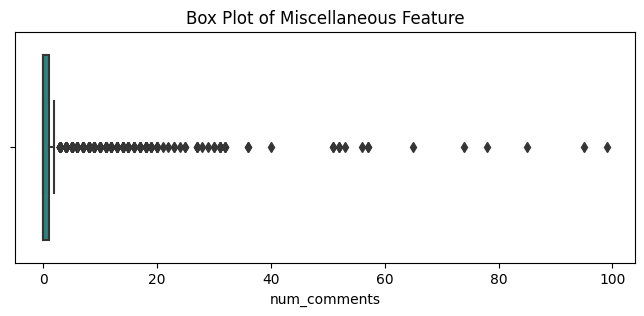

In [46]:
plt.figure(figsize=(8, 3))
sns.boxplot(data = df_combined, x = 'num_comments', palette = 'viridis')
plt.title("Box Plot of Miscellaneous Feature");

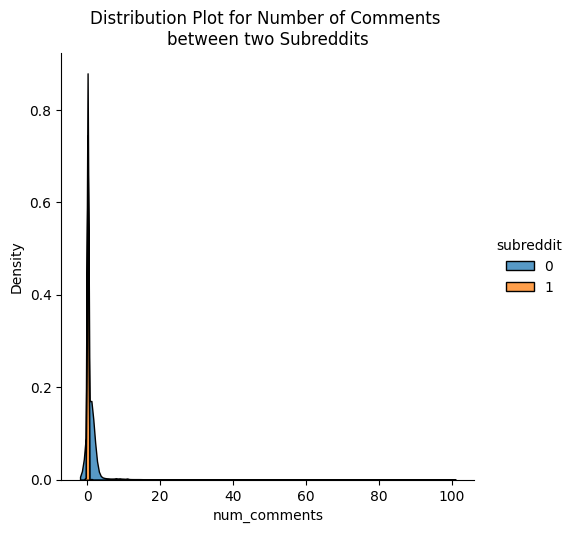

In [47]:
sns.displot(x='num_comments', data=df_combined, hue='subreddit', kind="kde", multiple="stack")
plt.title('Distribution Plot for Number of Comments \nbetween two Subreddits');

In [48]:
# drop columns that are not needed for analysis
df_combined.drop(columns = ['utc_datetime_str', 'selftext'], inplace = True)

In [49]:
df_combined.shape

(7604, 5)

In [50]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7604 entries, 0 to 7603
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     7604 non-null   int64 
 1   title         7604 non-null   object
 2   author        7604 non-null   object
 3   num_comments  7604 non-null   int64 
 4   text          7604 non-null   object
dtypes: int64(2), object(3)
memory usage: 297.2+ KB


In [51]:
# Save to csv
df_combined.to_csv("../data/df_combined.csv", index=False)

In [52]:
df_combined = pd.read_csv('../data/df_combined.csv')


### Text preprocessing

In [53]:
from bs4 import BeautifulSoup      

In [54]:
import spacy
#spacy.cli.download('en_core_web_md')

In [256]:
#spacy.cli.download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [55]:
# credit https://stackabuse.com/removing-stop-words-from-strings-in-python/
sp = spacy.load('en_core_web_sm')

stopwords_sp = sp.Defaults.stop_words
stopwords_sp.remove('not')
print(stopwords_sp)


{'down', 'upon', 'do', 'every', 'could', "'s", 'did', 'please', 'that', 'thence', 'off', 'the', 'various', 'forty', 'were', 'them', 'seeming', 'only', 'towards', 'make', 'everything', '’ve', 'along', 'no', 'wherever', 'had', 'everyone', 'mostly', 'our', 'third', "'ll", 'latter', 'twelve', 'about', 'we', 'two', 'own', 'up', 'until', 'same', 'who', 'less', 'go', 'enough', 'cannot', 'us', 'name', 'itself', 'seemed', 'seem', 'there', 'under', 'does', 'eleven', 'are', 'wherein', 'further', 'perhaps', 'formerly', 'too', 'here', 'what', 'between', 'besides', 'amongst', 'other', 'using', 'at', 'amount', 'herself', 'others', 'thereby', 'can', 'may', 'hereupon', 'say', 'put', 'someone', 'former', 'where', 'hundred', 'hers', 'on', 'noone', 'made', 'those', 'side', 'everywhere', 'back', '’d', 'beyond', 'whereafter', 'her', '‘d', 'again', 'nowhere', 'she', 'in', 'whose', 'get', 'than', '’m', 'one', 'always', '‘ll', 'whoever', 'though', 'now', 'per', 'why', 'nor', 'six', 'when', 'for', 'often', 'how

In [56]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize

In [57]:
from nltk.stem import WordNetLemmatizer

In [58]:
stopwords = set(stopwords.words('english'))
stopwords.remove('not')

In [59]:
print(stopwords)

{'out', "you've", 't', "needn't", 'those', 'down', 'its', 'do', 'didn', 're', 'yourself', "wouldn't", 'did', 'been', "isn't", 'i', "didn't", 'before', 'her', 'that', "you're", 'again', 'should', 'off', 'she', 'myself', 'it', 'in', 'will', 'to', 'o', 'than', 'the', 'shan', "won't", 'this', 'were', 'yourselves', 'a', 'haven', "couldn't", 'isn', 'them', 'mustn', 'have', 'now', 'these', 'he', 'why', "weren't", "you'd", 'because', 'only', 'yours', "you'll", "shan't", 'while', 'with', 'nor', 'your', "doesn't", 'all', "should've", 'or', "that'll", 'you', 'no', 'when', 'won', 'for', 'each', 'being', 'then', 'doesn', 'of', 'how', 'hasn', 'during', "don't", 'into', 'd', 'and', 'after', 'above', 'mightn', 'shouldn', 'our', 'had', 'by', 'hadn', 'him', "wasn't", 'they', 'don', 'about', 'we', 'more', 'me', 's', 'his', 'own', 'll', 'y', 'up', "shouldn't", 'until', 'such', 'same', 'couldn', 'theirs', 've', 'needn', 'who', 'any', 'be', 'having', 'ain', 'very', 'if', 'weren', 'm', 'itself', 'my', "she's

In [60]:
# credit: https://www.w3schools.com/python/gloss_python_join_sets.asp
all_stopwords = stopwords_sp.union(stopwords)

In [61]:
print(all_stopwords)

{'out', 't', 'down', 'upon', 'do', 'every', 'could', 'yourself', 'never', "'s", 'did', 'been', 'take', 'please', 'show', 'anyone', 'empty', "didn't", 'before', 'that', 'should', 'thence', 'off', 'myself', 'meanwhile', 'will', 'herein', 'the', 'various', 'call', 'five', 'forty', 'anyway', "won't", 'n’t', 'none', 'were', 'yourselves', 'a', 'around', 'afterwards', 'haven', "couldn't", 'isn', 'them', 'mustn', 'these', 'he', 'since', 'seeming', 'whereupon', 'only', 'because', 'really', 'yours', "shan't", 'another', 'while', 'with', "doesn't", 'towards', 'make', 'all', 'everything', "should've", '’ve', 'or', 'thereupon', 'whither', 'along', 'no', 'seems', 'being', 'hasn', "don't", 'into', 'd', 'mightn', 'wherever', 'shouldn', 'had', 'everyone', 'mostly', 'our', 'third', 'by', 'thru', "'ll", 'latter', 'twelve', 'nobody', 'due', "wasn't", 'don', 'about', 'would', 'we', 'two', '’s', 'alone', 'whereby', 'own', 'up', 'until', 'same', 'theirs', 'thus', 'who', 'less', 'go', 'must', 'ain', 'enough',

In [62]:
# additional keywords for removal
#add_stopwords = ['www', '.com', 'com', 'http', 'https']
#add_stopwords = set(add_stopwords)
#type(add_stopwords)

In [210]:
#more_stopwords = all_stopwords.union(add_stopwords)
#print(more_stopwords)

{'into', "it's", 'its', 'was', 'next', 'something', 'during', 'none', 'amongst', 'further', 'becomes', 'whether', "haven't", 'latterly', 'everywhere', 'call', 'quite', 'herself', 'two', "'re", 'without', 'here', 'various', 'first', 'using', 'between', 'rather', 'can', 'almost', 'about', 'again', 'made', 'alone', 'amount', 'http', "you're", 'ca', 'one', 'must', 'except', 'much', 'move', 'same', 'once', "you'd", 'haven', '’ll', 'nevertheless', 'are', 'also', 'herein', 'under', 'just', 'hereby', 'at', 'whom', 'whereas', 't', 'really', 'how', 'few', 'though', '‘d', 'even', 'per', 'whereupon', "mustn't", "needn't", 'noone', 'side', 'often', 'over', 'still', 'n‘t', 'which', 'nothing', 'my', 'needn', 'neither', 'several', 'this', 'last', 'thereupon', 'didn', "'d", 'yours', 'below', 'whole', 'theirs', 're', "'m", 'otherwise', 'wherever', 'anyhow', 'other', 'them', 'own', 'as', 'however', 'our', 'before', '’m', "you've", 'm', 'perhaps', 'therefore', 'sixty', 'somewhere', 'across', 'via', 'anywa

#### Tokenizing

In [63]:
# Import Tokenizer
from nltk.tokenize import RegexpTokenizer

# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+') 



In [64]:
from bs4 import BeautifulSoup   

In [112]:
#!pip install contractions

     ---------------------------------------- 0.0/289.9 kB ? eta -:--:--
     ------------------ ------------------- 143.4/289.9 kB 4.3 MB/s eta 0:00:01
     -------------------------------------- 289.9/289.9 kB 3.6 MB/s eta 0:00:00


#### Function for text cleaning

In [65]:
df_combined = pd.read_csv('../data/df_combined.csv')

In [66]:
import contractions

In [67]:
import unidecode

In [227]:
#pip install redditcleaner

Note: you may need to restart the kernel to use updated packages.


In [68]:
import redditcleaner

In [69]:
# adopted from class
# credit: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
# credit: https://www.geeksforgeeks.org/python-removing-newline-character-from-string/
# credit: https://stackoverflow.com/questions/43356467/removing-special-characters-and-symbols-from-a-string-in-python
# credit: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
# credit: https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb
# credit: https://pypi.org/project/redditcleaner/

# initialize list of newline characters
#newline_characters = ['\\ng', 'i\ns', 'b\nest', '\n\n', '\n', '\t', '\\']

def preprocess(text):

    # use redditcleaner to remove special characters used in the raw text at reddit
    # such as &amp;#x200B, newline_characters (\n\n)
    text = redditcleaner.clean(text)  
    
    # using contractions.fix to expand the shortened words
    text = contractions.fix(text)
        
    # convert to lowercase
    text = text.lower()
    
    # initiate BeautifulSopu to strip HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ") # Get all the text other than html tags.
    
    # remove links starts with https and/or end with .com
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\ *\.com', '', text)
    
    # remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)    
    
    # remove newlines tabs
    #for characters in newline_characters:
    #    text = text.replace(characters, ' ') 
    
    # remove extra white spaces
    text = re.sub('\s+', ' ', text).strip()  
  
    # split into individual words
    words = text.split()
        
    # remove stop words
    meaningful_words = []
    for w in words:
        if w not in all_stopwords:
            meaningful_words.append(w)
              
    # lemmatizer the words
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]    
    
    return ' '.join(tokens_lem)

In [70]:
df_combined['text_cleaned'] = df_combined.apply(lambda x: preprocess(x['text']), axis=1)
df_combined.head()

C:\Users\skyne\AppData\Local\Temp\ipykernel_35332\2602187967.py:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\skyne\AppData\Local\Temp\ipykernel_35332\2602187967.py:25: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


subreddit                                              title  \
0          1  Things I can get my boyfriend for his 1 month ...   
1          1                         Cheap last minute flights?   
2          1                                               trip   
3          1          Any CFAR insurance options after 21 days?   
4          1                                                Egi   

                 author  num_comments  \
0  AdministrativeLog689             0   
1              anon_157             0   
2  Curious-Campaign2376             0   
3      sweettangerine08             0   
4   travelw_theballards             0   

                                                text  \
0  Things I can get my boyfriend for his 1 month ...   
1  Cheap last minute flights? Apologies if this t...   
2                                              trip    
3  Any CFAR insurance options after 21 days? I'm ...   
4                                               Egi    

                                        text_cleaned  
0                 thing boyfriend month travel japan  
1  cheap minute flight apology type question aske...  
2                                               trip  
3  cfar insurance option day planning internation...  
4                                                egi

In [71]:
# before text cleaning
df_combined['text'][0:10].unique()

array(['Things I can get my boyfriend for his 1 month travel to Japan ',
       'Cheap last minute flights? Apologies if this type of question has been asked before. \n\nSomething has come up and I urgently need to meet my fiancé in London in around 2 weeks. Does anyone have any hacks to help be book the cheapest possible tickets from London? \n\nThank you in advance.',
       'trip ',
       "Any CFAR insurance options after 21 days? I'm planning my first international trip with my family. I didn't get CFAR insurance within the 14-21 day after initial purchase window. I put my deposit down in Jan 2023 and my trip is in July 2023. Any advice or recommendations? Thanks in advance!",
       'Egi ',
       "On my roadtrip should I opt to visit Sleeping bear dunes, Michigan or an extra night at Montreal? Currently I'm not going to Sleeping Bear Dunes. And will be staying at Montreal for 2 nights. \n\nI was thinking maybe to remove 1 night at Montreal and add Sleeping bear dunes\n\n&amp;#x2

In [72]:
# after text cleaning
df_combined['text_cleaned'][0:10].unique()

array(['thing boyfriend month travel japan',
       'cheap minute flight apology type question asked come urgently need meet fianc london week hack help book cheapest possible ticket london thank advance',
       'trip',
       'cfar insurance option day planning international trip family not cfar insurance day initial purchase window deposit jan trip july advice recommendation thanks advance',
       'egi',
       'roadtrip opt visit sleeping bear dune michigan extra night montreal currently not going sleeping bear dune staying montreal night thinking maybe remove night montreal add sleeping bear dune',
       'best purse traveling mexico specific recommendation purse mexico looking casual sling crossbody backpack purse tia',
       'advice avoiding pickpocket going prague couple day pickpocket thing told looking advice keeping wallet passport person thought',
       'use budget airline spirit frontier travel baby worth saving money like cheap airline tiniest seat designed single peop

In [73]:
df_combined.isna().sum()

subreddit       0
title           0
author          0
num_comments    0
text            0
text_cleaned    0
dtype: int64

In [78]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7604 entries, 0 to 7603
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     7604 non-null   int64 
 1   title         7604 non-null   object
 2   author        7604 non-null   object
 3   num_comments  7604 non-null   int64 
 4   text          7604 non-null   object
 5   text_cleaned  7604 non-null   object
dtypes: int64(2), object(4)
memory usage: 356.6+ KB


In [74]:
# Save to csv
df_combined.to_csv("../data/df_cleaned.csv", index=False)

In [75]:
df = pd.read_csv('../data/df_cleaned.csv')

In [76]:
#assign target and result to y and X then carry out train test split
y = df['subreddit']
X = df['text_cleaned']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)